In [1]:
from cycada_utils import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'On {device}')

Figure directory exists.
On cuda:0


In [2]:
class CyDataset(Dataset):
    def __init__(self):

        self.D = []
        self.L = []
                
        with open('/datacommons/carlsonlab/srs108/old/ol/Delhi_labeled.pkl', "rb") as fp:
            for station in pkl.load(fp):
#                 if station['PM25'] <600:
                self.D.append(tuple((station['Image'][:,:,:3], station['PM25'])))
                
        with open('/datacommons/carlsonlab/srs108/old/ol/Lucknow.pkl', "rb") as fp:
            for station in pkl.load(fp):
                for datapoint in station:
                    luck_img = datapoint['Image'][:,:,:3]
                    if luck_img.shape == (224, 224,3):  
                        self.L.append(tuple((luck_img, datapoint['PM'])))
                        
        self.L = random.choices(self.L, k= len(self.D))
        
    def __len__(self): return (len(self.D))
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        transform  = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.ToTensor()])

        d_img = self.D[idx][0]
        d_img = transform(d_img)        
        l_img = self.L[idx][0]
        l_img = transform(l_img)
        
        sample = {
              'D img': d_img,
              'D pm' : torch.tensor(self.D[idx][1]),
              'L img': l_img,
              'L pm' : torch.tensor(self.L[idx][1])
        }
        return sample

In [3]:
tr = CyDataset()
train, val = train_test_split(tr, test_size=0.2, random_state=42)
train_dataloader = DataLoader(
    train,
    batch_size=5, # 1
    shuffle=True)

val_dataloader = DataLoader(
    val,
    batch_size=1, # 1
    shuffle=True)

In [6]:
norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
generator_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/best_gens.pt')
discriminator_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/best_discs.pt')

#G's and D's will be pre loaded and set grad to false

G_ST = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)
G_ST.load_state_dict(generator_checkpoint['G_ST'])

G_TS = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)
G_TS.load_state_dict(generator_checkpoint['G_TS'])

D_T = NLayerDiscriminator(3)
D_T.load_state_dict(discriminator_checkpoint['D_T'])

D_S = NLayerDiscriminator(3)
D_S.load_state_dict(discriminator_checkpoint['D_S'])

D_ft = FeatureDiscriminator()

f_s = Multi_City_CNN()
f_s.load_state_dict(torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/saved_models/dlm4.pt'))

f_t = LeNet(3)
# f_t = Multi_City_CNN()
# f_t.load_state_dict(torch.load('dlm4.pt'))

G_ST.to(device)
G_TS.to(device)
D_S.to(device)
D_T.to(device)
D_ft.to(device)
f_s.to(device)
f_t.to(device)

ganloss = GANLoss().to(device)                         #use to fool discriminator
cycleloss = torch.nn.L1Loss().to(device)               #difference between reconstructed img and original
ftloss = torch.nn.modules.CrossEntropyLoss().to(device)            #difference between generator output from input img and input img
mseloss = torch.nn.MSELoss().to(device)       #difference between domain classifications between input img and generator output

optimizer_G = torch.optim.Adam(itertools.chain(G_ST.parameters(), G_TS.parameters()), lr=2e-4, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(itertools.chain(D_S.parameters(), D_T.parameters()), lr=1e-5, betas=(0.5, 0.999))
optimizer_f_s = torch.optim.Adam(f_s.parameters(), lr=1e-4, betas=(0.5, 0.999))  

optimizer_f_t = torch.optim.Adam(f_t.parameters(), lr=1e-5, betas=(0.5, 0.999))    #different learning rate??
optimizer_D_ft = torch.optim.Adam(D_ft.parameters(), lr=1e-5, betas=(0.5, 0.999))


D_ft.apply(weights_init_normal)
f_t.apply(weights_init_normal)

print()

In [15]:
def sample_images(dataloader, e, i, save=False):
    source = next(iter(dataloader))
    G_ST.eval()
    G_TS.eval()
    f_t.eval()
    real_source = source['D img'].type(Tensor) 
    fake_target = G_ST(real_source).detach()
    real_target = source['L img'].type(Tensor)
    real_lbl= source['D pm'].type(Tensor).float()
    fake_source = G_TS(real_target).detach()
    
    recons = G_TS(fake_target).detach()
    recont = G_ST(fake_source).detach() 

    real_S = make_grid(real_source, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_T = make_grid(fake_target, nrow=5, normalize=True, scale_each=True, padding=1)
    real_T = make_grid(real_target, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_S = make_grid(fake_source, nrow=5, normalize=True, scale_each=True, padding=1)
    reconS = make_grid(recons, nrow=5, normalize=True, scale_each=True, padding=1)
    reconT = make_grid(recont, nrow=5, normalize=True, scale_each=True, padding=1)

    source_pred = f_t(fake_target).squeeze(1)
    main_task_loss = mseloss(source_pred, real_lbl)
    print(f'PM Pred: {round(source_pred.item(),2)}\tPM True: {round(real_lbl.item(),2)}')

    # Arange images along y-axis    
    image_grid_1 = torch.cat((real_S, fake_T, reconS), 2)
    image_grid_2 = torch.cat((real_T, fake_S, reconT), 2)
    fig, ax = plt.subplots(2,1)
    ax[0].imshow(image_grid_1.cpu().permute(1,2,0))
    ax[1].imshow(image_grid_2.cpu().permute(1,2,0))
    ax[0].set_title('Real Source  | Fake Target | Recon Source')
    ax[1].set_title('Real Target | Fake Source | Recon Target')
    
    ax[0].axis('off')
    ax[1].axis('off')
    plt.gcf().set_size_inches(10, 6)
    if save:
        plt.savefig(os.path.join('Figure_PDFs', f'epoch_{str(e+1)}_iter{str(i+1)}_prediction_{round(source_pred.detach().item(),2)}_real_{round(real_lbl.detach().item(),2)}.png'), bbox_inches='tight', pad_inches=0, facecolor='white')
    plt.show();

PM Pred: 93.66	PM True: 114.25


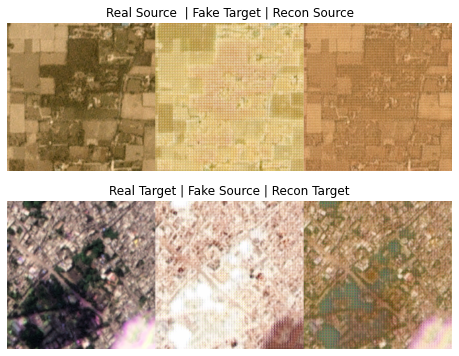

PM Pred: 95.34	PM True: 139.74


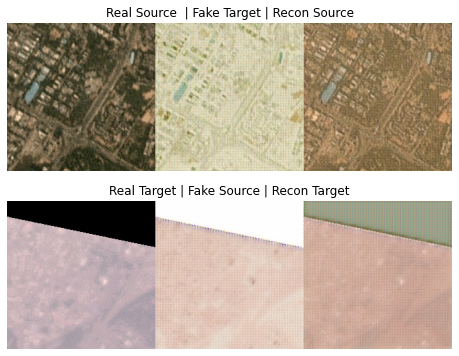


Epoch 1/2 finished at 08:50:17.412389


PM Pred: 97.14	PM True: 55.02


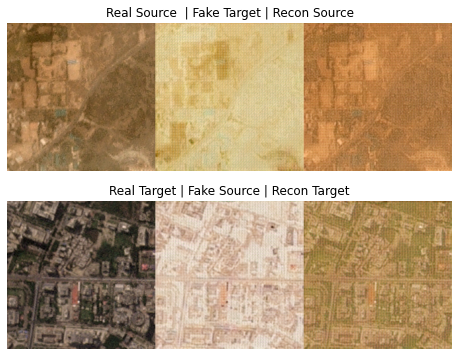

PM Pred: 94.79	PM True: 87.19


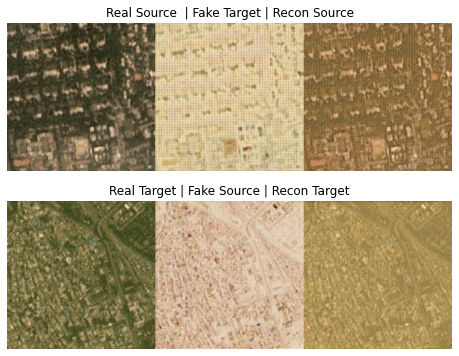


Epoch 2/2 finished at 08:56:28.092685


In [8]:
Tensor  = torch.cuda.FloatTensor
history = {'epoch':[], 'Dft_loss':[],'mainloss':[], 'batch':[]}
final = {'PM_pred':[], 'PM_true': []}
num_classes = 2
best_main_loss = 1e6
best_dft_loss = 1e6
n_epochs = 200

for e in range(n_epochs):
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        real_S = batch['D img'].type(Tensor)
        real_T = batch['L img'].type(Tensor)
        real_lbl = batch['D pm'].type(Tensor).float()
          
            
        source_label = torch.ones(real_S.size()[0]).long().to(device)
        target_label = torch.zeros(real_T.size()[0]).long().to(device)
          
        #Generator Forward Pass
        G_ST.train()
        G_TS.train()
        
        fake_t         = G_ST(real_S)             #source domain img, styled as target
        fake_s         = G_TS(real_T)             #target domain img, styled as source
        
        recov_s        = G_TS(fake_t)
        recov_t        = G_ST(fake_s)
          
            
        pred_faketarg  = f_t(fake_t.detach()) # (f_t(G_ST(S)))
        pred_target    = f_t(real_T)         # (f_t(T))
# ---------------------------------------------------------------------------------------------------------
# Run Regressor f_s  L_SEM = Ltask + Ltask; PRETRAINED-- PHASE ONE
# ---------------------------------------------------------------------------------------------------------
        set_requires_grad([f_s],requires_grad=False)
        optimizer_f_s.zero_grad()
    
        #Run real img and stylistically transformed img through pretrained network, need 4 instances
        pm_from_real_S  = f_s(real_S).squeeze(1)
        pm_from_fake_T  = f_s(fake_t.detach()).squeeze(1)
        
        pm_from_real_T  = f_s(real_T).squeeze(1)
        pm_from_fake_S  = f_s(fake_s.detach()).squeeze(1)

        #compute MSE from PM values ***predicted*** from real image and fake image (same pm vals tho!!)
        #DO NOT ASSESS WITH REAL PM LABEL, BUT WITH PREDICTION
        
        sem_loss_source    = mseloss(pm_from_real_S, pm_from_fake_T)  #Ltask(fs, G_TS(T), p(fs, T))                   
        sem_loss_targ      = mseloss(pm_from_real_T,pm_from_fake_S)   #Ltask(fs, G_ST(S), p(fs, S))
        sem_loss           = (sem_loss_source + sem_loss_targ)/2
        
#         sem_loss.backward()
        optimizer_f_s.step()
        
# -------------------------------------------------------------------------------------------------------
# Train Generators G_ST and G_TS L_CYC; PRETRAINED-- PHASE TWO
# -------------------------------------------------------------------------------------------------------
        set_requires_grad([D_S, D_T],requires_grad=False)
        set_requires_grad([G_ST, G_TS],requires_grad=False)
        optimizer_G.zero_grad()
    
        #****train Generator to produce convincing results to fool D****
        #extra ganloss run not included in objective......
        
        loss_GAN_S, _  = ganloss(D_S(fake_t), True)  #L(D_S(G_ST(S)))             
        loss_GAN_T, _ = ganloss(D_T(fake_s), True)  #L(D_T(G_TS(T)))               
        
        # cycle loss (L1 Loss)      
        loss_cycle_S   = cycleloss(recov_s, real_S)    # Lcyc(G_TS(G_ST(S)), S)
        loss_cycle_T   = cycleloss(recov_t, real_T)    # Lcyc(G_ST(G_TS(T)), T)
        loss_cycle     = loss_cycle_S + loss_cycle_T
        
        
        loss_G = loss_GAN_S + loss_GAN_T + loss_cycle
                
#         loss_G.backward()
        optimizer_G.step()
        
# -------------------------------------------------------------------------------------------------------
# Train Discriminator S and Discriminator T L_GAN, L_GAN; PRETRAINED-- PHASE TWO
# -------------------------------------------------------------------------------------------------------
        set_requires_grad([D_S, D_T],requires_grad=False)
        optimizer_D.zero_grad()
        
        loss_real_s, _ = ganloss(D_S(real_S), True)               
        loss_fake_s, _ = ganloss(D_S(fake_s.detach()), False)   
        
        loss_D_S       = (loss_real_s + loss_fake_s)/2
        
        loss_real_t, _ = ganloss(D_T(real_T), True)              
        loss_fake_t, _ = ganloss(D_T(fake_t.detach()), False)  
        
        loss_D_T       = (loss_real_t + loss_fake_t)/2
        loss_D         = (loss_D_S + loss_D_T)/2

#         loss_D.backward()
        optimizer_D.step()
        
# -----------------------------------------------------------------------------------------------------------
# Train Feature Dsicriminator D_ft L_GAN; PHASE THREE
# -----------------------------------------------------------------------------------------------------------
        set_requires_grad([D_ft], True)
        set_requires_grad([f_t], False)    
        optimizer_D_ft.zero_grad()
        D_ft.train()

#         print(pred_faketarg.shape)
        dft_pred_fakeT  = D_ft(pred_faketarg)        # D_ft(f_t(G_ST(S)))
        dftpred_target  = D_ft(pred_target )          # D_ft(f_t(T))
        
        #feature discriminator accuracy and L_GAN(f_t, Dfeat, ft(G_ST(S)), XT), recall discriminators are trained to the point
        L1, acc_fakeT = ganloss(dft_pred_fakeT, False)
        L2, acc_realT = ganloss(dftpred_target, True)
        
        
        dft_acc = (acc_fakeT + acc_realT) *0.5
        dft_loss = (L1 + L2)*0.5
        dft_loss.backward()
        optimizer_D_ft.step()
    
# -----------------------------------------------------------------------------------------------------------
# Train Classifier Network f_t L_Task; PHASE THREE
# -----------------------------------------------------------------------------------------------------------
        set_requires_grad([D_ft], False)
        set_requires_grad([f_t], True)
        optimizer_f_t.zero_grad()
        
        f_t.train()
        
        #MAIN TASK (PM prediction on noisiy image, but if featuer discriminator is good, we predict on the target?)
        source_pred = f_t(fake_t.detach()).squeeze(1)
        main_task_loss = mseloss(source_pred, real_lbl)  #PM prediction loss

        if dft_acc > 0.6:
#             print(f'adv: {dft_acc}')
            real_targ_pred = D_ft(f_t(real_T.detach()))   #D_ft(f_t(T))
            adv_ft_loss = ftloss(real_targ_pred, target_label)    #cross entropy loss makes sense for future multi city
        else: adv_ft_loss = 0
            
        total_ft_loss = main_task_loss + adv_ft_loss
        
        total_ft_loss.backward()
        optimizer_f_t.step()
# -----------------------------------------------------------------------------------------------------------
# MODEL SAVING
# -----------------------------------------------------------------------------------------------------------
        if dft_loss < best_dft_loss:
            best_dft_loss = dft_loss
            torch.save({ 'D_ft': D_ft.state_dict()}, 'best_dft.pt')
 
        if main_task_loss < best_main_loss:
            best_main_loss = main_task_loss
            torch.save({ 'f_t': f_t.state_dict()}, 'best_main.pt')
            
        if (e+1) % n_epochs == 0:
            for (prediction, lbl) in zip (source_pred.detach().cpu().numpy(), real_lbl.detach().cpu().numpy()):
                final['PM_pred'].append(prediction)
                final['PM_true'].append(lbl)
# ---------------------------------Visualization and Saving---------------------------------      
        
        if (i+1) % 2500 == 0:
            with torch.no_grad():
                sample_images(val_dataloader,e,i,save=True)
                history['Dft_loss'].append(dft_loss.item())
                history['batch'].append(i+1)
                history['epoch'].append(e+1)
                history['mainloss'].append(main_task_loss.item())


    now = datetime.datetime.now()
    print(f"Epoch {e + 1}/{n_epochs} finished at {now.time()}") #\n\ [G Loss: {loss_G.item()}]\t[D Loss: {loss_D.item()}]\t[Cycle Loss: {loss_cycle.item()}]")

In [9]:
df = pd.DataFrame(history)
df.to_csv('history.csv', index=False)

gf = pd.DataFrame(final)
gf.to_csv('PMs.csv',index=False)

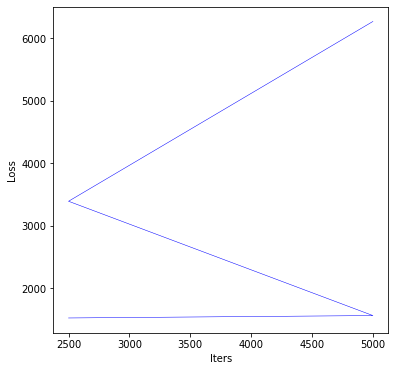

In [10]:
trainloss(df['mainloss'], df['batch'], save = True, fig_name='PM_loss')

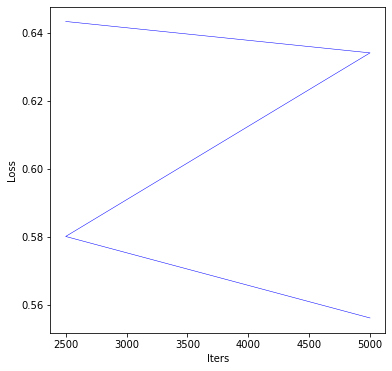

In [11]:
trainloss(df['Dft_loss'], df['batch'], save = True, fig_name='dft_loss')

In [12]:
from scipy import stats
from sklearn import metrics


# To evaluate the statistics between predicted and true PM2.5
def eval_stat(y_train_pred, y_train):
    Rsquared = stats.spearmanr(y_train_pred, y_train.ravel())[0]
    pvalue = stats.spearmanr(y_train_pred, y_train.ravel())[1]
    Rsquared_pearson = stats.pearsonr(y_train_pred, y_train.ravel())[0]
    pvalue_pearson = stats.pearsonr(y_train_pred, y_train.ravel())[1]
    return Rsquared, pvalue, Rsquared_pearson, pvalue_pearson

# To plot the predicted and true PM2.5 along with the calculated statistics
def plot_result(y_train_pred, y_train, Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, plot_label="train", lower_bound=0, upper_bound=175,
                save = True, fig_name = ''):
    plt.rcParams.update({'mathtext.default':  'regular' })
    my_prediction = y_train_pred
    fig, ax = plt.subplots(figsize = (7,7))
#     plt.ylim([0,max(y_train_pred)])
    ax.scatter(y_train, my_prediction,color = 'green', edgecolors=(0, 0, 0),  s = 100)
    ax.plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'k--', lw=4)
    ax.set_xlabel('True $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 20)
    ax.set_ylabel('Predicted $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 20)
    ax.tick_params(labelsize = 10)
    fig.text(0.15, 0.85, 'Spearman r = '+ str(round(Rsquared,2)), fontsize=15)
    fig.text(0.15, 0.82, 'Spearman p-value = '+ str(round(pvalue,2)),fontsize=15)
    plt.axis('tight')
    fig.text(0.15, 0.79, 'Pearson r = '+ str(round(Rsquared_pearson,2)),fontsize=15)
    fig.text(0.15, 0.76, 'Pearson p-value = '+ str(round(pvalue_pearson,3)),fontsize=15)
    fig.text(0.15, 0.73, 'RMSE = '+ str(round(np.sqrt(metrics.mean_squared_error(y_train, my_prediction)),2)),fontsize=15)
    fig.text(0.15, 0.70, 'MAE = '+ str(round(metrics.mean_absolute_error(y_train, my_prediction),2)),fontsize=15)
    fig.text(0.15, 0.67, '% error = '+ str(round(metrics.mean_absolute_error(y_train, my_prediction)/np.mean(y_train)*100,1))+'%', fontsize=15)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    if save:
        fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.png', transparent=False, facecolor='white', bbox_inches='tight')
  
    pass
    return

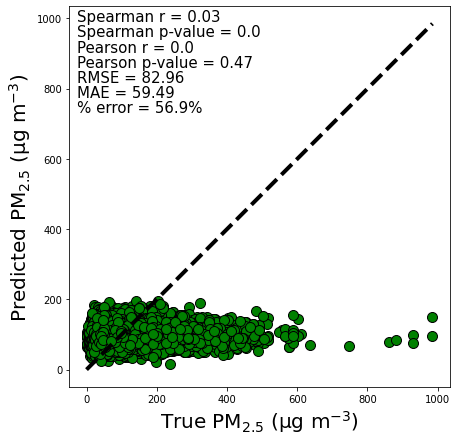

In [13]:
Rsquared, pvalue, Rsquared_pearson, pvalue_pearson =eval_stat(gf['PM_pred'], gf['PM_true'])
plot_result(gf['PM_pred'], gf['PM_true'], Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, plot_label="train", lower_bound=0, upper_bound=max(gf['PM_true']),
                save = True, fig_name = 'eval_stats')

In [4]:
norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
generator_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/best_gens.pt')
discriminator_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/best_discs.pt')
feature_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/feature_level/best_dft.pt')
main_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/feature_level/best_main.pt')
#G's and D's will be pre loaded and set grad to false

G_ST = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)
G_ST.load_state_dict(generator_checkpoint['G_ST'])

G_TS = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)
G_TS.load_state_dict(generator_checkpoint['G_TS'])

D_T = NLayerDiscriminator(3)
D_T.load_state_dict(discriminator_checkpoint['D_T'])

D_S = NLayerDiscriminator(3)
D_S.load_state_dict(discriminator_checkpoint['D_S'])

D_ft = FeatureDiscriminator()
D_ft.load_state_dict(feature_checkpoint['D_ft'])

f_s = Multi_City_CNN()
f_s.load_state_dict(torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/saved_models/dlm4.pt'))

f_t = LeNet(3)
f_t.load_state_dict(main_checkpoint['f_t'])


G_ST.to(device)
G_TS.to(device)
D_S.to(device)
D_T.to(device)
D_ft.to(device)
f_s.to(device)
f_t.to(device)

ganloss = GANLoss().to(device)                         
cycleloss = torch.nn.L1Loss().to(device)               
ftloss = torch.nn.modules.CrossEntropyLoss().to(device)          
mseloss = torch.nn.MSELoss().to(device)      

optimizer_G = torch.optim.Adam(itertools.chain(G_ST.parameters(), G_TS.parameters()), lr=2e-4, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(itertools.chain(D_S.parameters(), D_T.parameters()), lr=1e-5, betas=(0.5, 0.999))
optimizer_f_s = torch.optim.Adam(f_s.parameters(), lr=1e-4, betas=(0.5, 0.999))  

optimizer_f_t = torch.optim.Adam(f_t.parameters(), lr=1e-5, betas=(0.5, 0.999))    #different learning rate??
optimizer_D_ft = torch.optim.Adam(D_ft.parameters(), lr=1e-5, betas=(0.5, 0.999))


print()

In [1]:
# Tensor  = torch.cuda.FloatTensor
# final = {'PM_pred':[], 'PM_true': []}

# with torch.no_grad():
#     for i, batch in tqdm(enumerate(val_dataloader)):
#         f_t.eval()
#         G_ST.eval()
#         G_TS.eval()
        
                
#         real_S = batch['D img'].type(Tensor)
#         real_T = batch['L img'].type(Tensor)
#         real_lbl = batch['D pm'].type(Tensor).float()
        
#         fake_t         = G_ST(real_S)             #source domain img, styled as target
#         fake_s         = G_TS(real_T)             #target domain img, styled as source
        
#         recov_s        = G_TS(fake_t)
#         recov_t        = G_ST(fake_s)
          
            
#         pred_faketarg  = f_t(fake_t.detach()) # (f_t(G_ST(S)))
#         pred_target    = f_t(real_T)         #
#         source_pred = f_t(fake_t.detach()).squeeze(1)
#         main_task_loss = mseloss(source_pred, real_lbl)
# #         print(main_task_loss)
#         final['PM_pred'].append(source_pred.item())
#         final['PM_true'].append(real_lbl.item())
        
#         sample_images(val_dataloader,0,i,save=False)


In [11]:
gf = pd.DataFrame(final)
# gf.to_csv('PMs.csv',index=False)

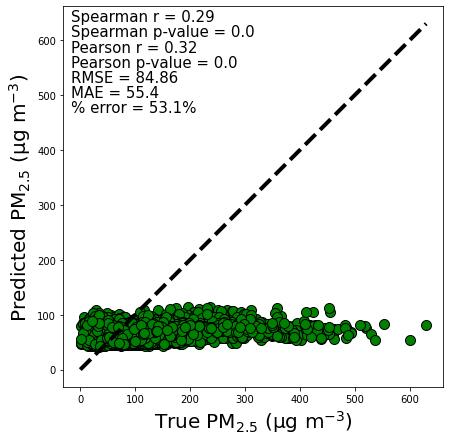

In [13]:
Rsquared, pvalue, Rsquared_pearson, pvalue_pearson =eval_stat(gf['PM_pred'], gf['PM_true'])
plot_result(gf['PM_pred'], gf['PM_true'], Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, plot_label="train", lower_bound=0, upper_bound=max(gf['PM_true']),
                save = True, fig_name = 'eval_stats')